In [1]:
from fastai.text import *

In [65]:
def calc_cat1(answers, truth):
    # (1/n)*(nc+(nu*nc/n))
    n_correct = 0
    n_undecided = 0
    n = len(answers)
    for k, v in enumerate(answers):
        if v == 0.5:
            n_undecided += 1
        else:
            n_correct += (v > 0.5) == truth[k]

    scale = 1.0 / n
    return (n_correct + n_undecided * n_correct * scale) * scale

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.set_device('cuda:0')

In [11]:
df_train = pd.read_csv('./data_new/pan_13_cls/train.csv')
df_test01 = pd.read_csv('./data_new/pan_13_cls/test01.csv')
df_test02 = pd.read_csv('./data_new/pan_13_cls/test02.csv')
df_train.head()

,label,k_doc,u_doc
0,Y,Computer simulation is used to reduce the risk...,"After the model has been conceptualized, coded..."
1,N,Computer simulation is used to reduce the risk...,Data model design belongs to the first develop...
2,Y,Digital signal processing (DSP) has become a c...,"Consider a periodic digital signal x[n], n=0,1..."
3,N,Digital technology has become widespread and e...,"For a digital signal x[n], the discrete Fourie..."
4,Y,Programming is not only coding. Primarily it i...,When working with data from files and database...


In [17]:
len(df_train), len(df_test01), len(df_test02)

(10, 20, 30)

In [12]:
df_doconly = pd.concat( [df_train, df_test01, df_test02] )
df_doconly = pd.concat( [df_doconly["k_doc"], df_doconly["u_doc"]] )
df_doconly = pd.DataFrame( df_doconly.unique() )
df_doconly

,0
0,Computer simulation is used to reduce the risk...
1,Digital signal processing (DSP) has become a c...
2,Digital technology has become widespread and e...
3,Programming is not only coding. Primarily it i...
4,High-content screening can easily generate mor...
...,...
64,Every transaction is somehow dated and the rel...
65,It is said the future of publishing rests with...
66,The order of the filter can be increased to ob...
67,NetBeans has a visual tool to help with the de...


In [13]:
db = TextLMDataBunch.from_df('./data_new/pan_13_cls/',
                            train_df=df_doconly[:55], valid_df=df_doconly[55:],
                            text_cols=0)

/home/aeryen/Code/04_Paper_AV/fastai/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [14]:
len( db.vocab.itos )

5416

## Train the LM

In [15]:
learn = language_model_learner(db, AWD_LSTM)

In [16]:
moms = (0.8,0.7)
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,4.901245,4.388126,0.271563,00:02
1,4.280287,3.870520,0.288080,00:02
2,3.673325,3.700478,0.306518,00:02
3,3.165907,3.599847,0.318839,00:02
4,2.761493,3.579676,0.320536,00:02
5,2.512954,3.570171,0.321741,00:02


## Show some text

In [22]:
learn.beam_search("And do your best to", 10)

"And do your best to And do your best to - night , Mr. Slocum , do n't"

In [21]:
learn.predict( "Oh, if you only would. I'd just love", n_words=20 )

"Oh, if you only would. I'd just love to see what you 'd do to do n't asleep . i 'd 've come in , Rogie ."

# ============

In [69]:
def gen_ku_pairs(learn, k_doc, u_doc):
    model = learn.model
    model.reset()
    model = model.eval()
    
    pred_enc = model[0]
    doc_enc = model[0].encoder
    
#     k_doc = df_test.iloc[0,1]
#     u_doc = df_test.iloc[0,2]
    
    k_ids, _ = learn.data.one_item(k_doc)
    u_ids, _ = learn.data.one_item(u_doc)
    
    with torch.no_grad():
        pred_enc.reset()
        k_embed = doc_enc(k_ids).detach()
        # we are using raw, dont care for dropout atm
        k_pred = pred_enc(k_ids)[0][-1].detach()
        
        pred_enc.reset()
        u_embed = doc_enc(u_ids).detach()
        u_pred = pred_enc(u_ids)[0][-1].detach()
        
        return k_embed, k_pred, u_embed, u_pred

In [67]:
def docmat_to_docvec(mat, reduce):
    if reduce == "mean":
        return mat.mean(dim=0)
    elif reduce == "max":
        return torch.max(mat, dim=0)[0]
    elif reduce == "meanmax":
        return torch.cat( [mat.mean(dim=0), torch.max(mat, dim=0)[0]] )

def pred_diff_reduce_cosine(learn, df, reduce="mean"):
    k_dv_list = []
    u_dv_list = []
    dist_list = []
    for i in range(len(df)):
        print(i)
        k_embed, k_pred, u_embed, u_pred = gen_ku_pairs(learn, df.iloc[i,1], df.iloc[i,2])
        k_dv = k_embed[0,1:,:] - k_pred[0,:-1,:]
        k_dv = docmat_to_docvec(k_dv, reduce)
        k_dv_list.append(k_dv.numpy())
        
        u_dv = u_embed[0,1:,:] - u_pred[0,:-1,:]
        u_dv = docmat_to_docvec(u_dv, reduce)
        u_dv_list.append(u_dv.numpy())
        
        dv_dist = torch.nn.functional.cosine_similarity(k_dv, u_dv, dim=0)
        dist_list.append(dv_dist.numpy())
        
    return  np.array(k_dv_list), np.array(u_dv_list), np.array(dist_list)

def pred_cosine_reduce_cosine(learn, df, reduce="mean"):
    k_dv_list = []
    u_dv_list = []
    dist_list = []
    for i in range(len(df)):
        print(i)
        k_embed, k_pred, u_embed, u_pred = gen_ku_pairs(learn, df.iloc[i,1], df.iloc[i,2])
        k_embed = k_embed[0,1:,:]
        k_pred = k_pred[0,:-1,:]
        cs1_values = torch.nn.functional.cosine_similarity(k_embed, k_pred, dim=1)
        cs1_sel = cs1_values < torch.median(cs1_values)
        k_dv = k_embed[cs1_sel,:] - k_pred[cs1_sel,:]
        k_dv = docmat_to_docvec(k_dv, reduce)
        k_dv_list.append(k_dv)
        
        u_embed = u_embed[0,1:,:]
        u_pred = u_pred[0,:-1,:]
        cs1_values = torch.nn.functional.cosine_similarity(u_embed, u_pred, dim=1)
        cs1_sel = cs1_values < torch.median(cs1_values)
        u_dv = u_embed[cs1_sel,:] - u_pred[cs1_sel,:]
        u_dv = docmat_to_docvec(u_dv, reduce)
        u_dv_list.append(u_dv)
        
        dv_dist = torch.nn.functional.cosine_similarity(k_dv, u_dv, dim=0)
        dist_list.append( dv_dist.cpu().numpy() )
        
    return  np.array(k_dv_list), np.array(u_dv_list), np.array(dist_list)

def pred_raw(learn, df, reduce="mean"):
    k_embed_list = []
    k_pred_list = []
    u_embed_list = []
    u_pred_list = []
    label_list = []
    for i in range(len(df)):
        print(i)
        k_embed, k_pred, u_embed, u_pred = gen_ku_pairs(learn, df.iloc[i,1], df.iloc[i,2])
        k_dv = k_embed[0,1:,:] - k_pred[0,:-1,:]
        k_embed_list.append( k_embed[0,1:,:] )
        k_pred_list.append( k_pred[0,:-1,:] )
        
        u_dv = u_embed[0,1:,:] - u_pred[0,:-1,:]
        u_dv = docmat_to_docvec(u_dv, reduce)
        u_dv_list.append(u_dv.numpy())
        
    return  np.array(k_dv_list), np.array(u_dv_list), np.array(dist_list)

In [68]:
def get_dvs(learn, df):
    with torch.no_grad():
        k_dvs, u_dvs, dists = pred_cosine_reduce_cosine(learn, df)
    
    pred = dists > np.median(dists)
    truth = ( df["label"] == "Y" ).to_numpy()
    
    acc = np.sum( pred == truth ) / len(truth)
    print(acc)
    
    return k_dvs, u_dvs, dists

In [70]:
# Generate Training Set DV
train_k_dvs, train_u_dvs, train_dists = get_dvs(learn, df_train)

0
1
2
3
4
5
6
7
8
9
0.8


In [71]:
# Generate Eval Set DV
eval_k_dvs, eval_u_dvs, eval_dists = get_dvs(learn, df_test02)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0.7


# ====================

In [45]:
train_y = ( df_train["label"].to_numpy() == "Y" ).astype(np.int)
# train_y = torch.tensor(train_y).cuda().double()
# train_y = train_y.unsqueeze(dim=-1)

eval_y = ( df_test["label"].to_numpy() == "Y").astype(np.int)
# eval_y = torch.tensor(eval_y).cuda().double()
# eval_y = eval_y.unsqueeze(dim=-1)

# =============================================

In [29]:
class ConcatClas(nn.Module):
    def __init__(self):
        super(ConcatClas, self).__init__()
        layer_1 = []
        layer_1.append( torch.nn.BatchNorm1d(400) )
        layer_1.append( torch.nn.Dropout(0.5) )
        layer_1.append( torch.nn.Linear(400, 1) )
#         layer_1.append( torch.nn.GELU() )
        self.l1 = nn.Sequential(*layer_1)
#         layer_2 = []
#         layer_2.append( torch.nn.BatchNorm1d(32) )
#         layer_2.append( torch.nn.Dropout(0.1) )
#         layer_2.append( torch.nn.Linear(32, 1) )
#         layer_2.append( torch.nn.Sigmoid() )
#         self.l2 = nn.Sequential(*layer_2)
        
    def forward(self, k_dv, u_dv):
#         dvs = torch.cat( (k_dv, u_dv), dim=1 )
        dvs = k_dv - u_dv
        t = self.l1(dvs)
#         t = self.l2(t)
        return t
        

In [30]:
def eval_acc(model, k_dvs, u_dvs, lbl):
    all_pred = []
    loss_list = []
    model.eval()
    with torch.no_grad():
        for i in range( int(len(lbl)/25) ):
#             print("step: " + str(i))
            xk = torch.tensor( k_dvs[(i*25):((i+1)*25), :] ).cuda()
            xu = torch.tensor( u_dvs[(i*25):((i+1)*25), :] ).cuda()
            y_pred = model(xk, xu)
            
            loss = F.binary_cross_entropy_with_logits(input=y_pred, target=lbl[(i*25):((i+1)*25), :])
            loss_list.append(loss.detach().cpu().numpy())
            
            all_pred.append( y_pred.detach().cpu().numpy() )
    all_pred = np.concatenate(all_pred)
    pred_tf = all_pred > np.median(all_pred)
    acc = np.sum( lbl.cpu().numpy() == pred_tf ) / len(lbl)
    print(acc)
    
    return all_pred, np.array(loss_list).mean()

In [36]:
model = ConcatClas()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
eval_loss = []
model = model.cuda()
for epoch in range(30):
    model.train()
    for i in range( int(len(train_y)/25) ):
        optimizer.zero_grad()
        xk = torch.tensor( train_k_dvs[(i*25):((i+1)*25), :] ).cuda()
        xu = torch.tensor( train_u_dvs[(i*25):((i+1)*25), :] ).cuda()
        y_pred = model(xk, xu)
        
        loss = F.binary_cross_entropy_with_logits(input=y_pred, target=train_y[(i*25):((i+1)*25), :])
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
        print("train: " + str(train_loss[-1]) )

        
    pred, loss = eval_acc(model, eval_k_dvs, eval_u_dvs, eval_y)
    eval_loss.append( loss )
    print("+++ eval: " + str(loss) )
    
    


train: 0.7000899907926469
train: 0.7749779593576943
train: 0.8003144140471272
train: 0.8594630214691973
0.616
+++ eval: 0.6848077628953507
train: 0.6510298297324066
train: 0.6375039762816431
train: 0.7147838964734097
train: 0.8399711644655947
0.608
+++ eval: 0.6855422703241791
train: 0.5633849530655526
train: 0.6892517361957189
train: 0.7007255910174786
train: 0.8918429091905893
0.604
+++ eval: 0.6865546914885631
train: 0.5999261218325913
train: 0.7417572243118903
train: 0.6153397506026976
train: 0.7033520988370751
0.596
+++ eval: 0.6880841314252285
train: 0.5293864254045537
train: 0.6066917379194852
train: 0.7386041774167673
train: 0.7168000464856611
0.588
+++ eval: 0.6902702353424524
train: 0.542028308018409
train: 0.6203805042718236
train: 0.696202807958361
train: 0.7329040391839134
0.564
+++ eval: 0.6935402933014859
train: 0.5121326738864328
train: 0.6049202327820604
train: 0.6139946251959807
train: 0.6855665429182375
0.548
+++ eval: 0.6980374176456607
train: 0.4719082664271829
tra

In [57]:
pred

(500, 1)

In [38]:
len(train_loss)

40

In [32]:
import matplotlib
import matplotlib.pyplot as plt

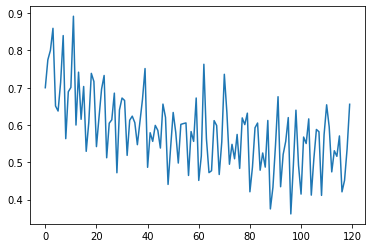

In [37]:
fig, ax = plt.subplots()
ax.plot(train_loss)
plt.show()

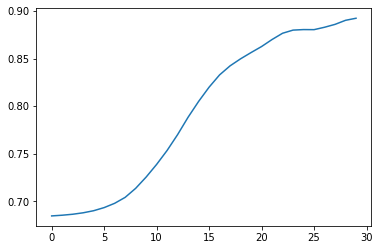

In [38]:
fig, ax = plt.subplots()
ax.plot(eval_loss)
plt.show()

# SVM =======================

In [41]:
from sklearn import svm

In [64]:
for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVC(kernel=kern)
    
    train_feat = np.concatenate([train_k_dvs-train_u_dvs, train_dists[:,None]], axis=1)
    clf.fit( train_feat, train_y )
    
    eval_feat = np.concatenate([eval_k_dvs-eval_u_dvs, eval_dists[:,None]], axis=1)
    pred_y = clf.predict( eval_feat )
    
    correct = pred_y == eval_y
    acc = sum(correct) / len(correct)
    print("kernel: " + kern + " acc: " + str(acc))

kernel: linear acc: 0.4666666666666667
kernel: poly acc: 0.4666666666666667
kernel: rbf acc: 0.6666666666666666
kernel: sigmoid acc: 0.5
